In [2]:
# Scientific imports

%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Observations
from astroquery.mast import Catalogs

# General imports

import csv, math, os, os.path, sys
import pandas as pd
import seaborn as sb
from sklearn import metrics
from IPython.display import display
sb.set()

# File imports

import data_header_check

As per last meeting, I am going to ensure that all python file names have underscores "\_" instead of hyphens "-" in filenames to facilitate ease of importing, as done so above.

Additionally, we realised that whereas I thought that the three necessary fields were Time, Phase, and Flux, we worked out that Phase is just a re-ordering of time (and so even if Phase isn't present, we can still manually work it out.

Therefore, all we need to find is the Time series of Light recordings, and the rest can be worked out algorithmically or via ML methods.

\#  
\#  
\#  
I will do everything **manually** first, so I know how to do ir, and once performed manually I can work on making a ML algorithm to do it for me!  
\#  
\#  
\#  

In [198]:
fitsList = []
fits_directories = [x[0] for x in os.walk('.')]

for fits_root, fits_dirs, fits_files in os.walk('.'):
    for fits_file in fits_files:
        fullpath = os.path.join(fits_root, fits_file)
        if (os.path.splitext(fullpath.lower())[1]).endswith('.fits'):
            fitsList.append(fullpath)
print("Number of FITS files: {}".format(len(fitsList)))

Number of FITS files: 28


Using the code from [this workbook](20191105%20-%20Segregating%20TESS%20missions.ipynb):

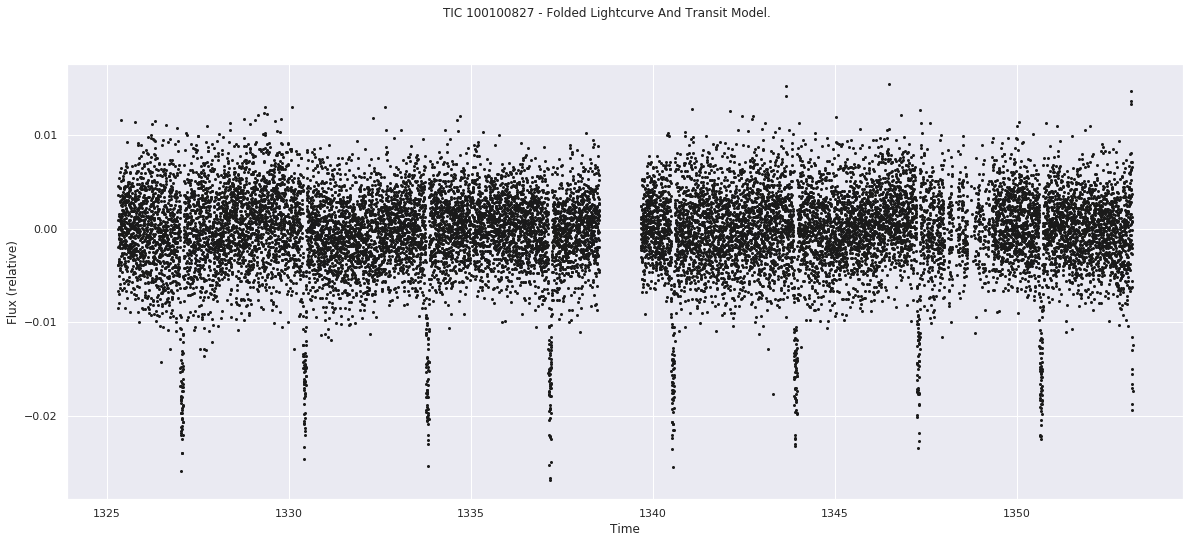

In [200]:
with fits.open(fitsList[4], mode="readonly") as hdulist:
    
    # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
    # and TESS magnitude.
    #####star_teff = hdulist[0].header['TEFF']
    #####star_logg = hdulist[0].header['LOGG']
    #####star_tmag = hdulist[0].header['TESSMAG']
    
    # Extract some of the fit parameters for the first TCE.  These are stored in the FITS header of the first
    # extension.
    #####period = hdulist[1].header['TPERIOD']
    #####duration = hdulist[1].header['TDUR']Working on ifitsList = []
fits_directories = [x[0] for x in os.walk('.')]

for fits_root, fits_dirs, fits_files in os.walk('.'):
    for fits_file in fits_files:
        fullpath = os.path.join(fits_root, fits_file)
        if (os.path.splitext(fullpath.lower())[1]).endswith('.fits'):
            fitsList.append(fullpath)
print("Number of FITS files: {}".format(len(fitsList)))
    #####epoch = hdulist[1].header['TEPOCH']
    #####depth = hdulist[1].header['TDEPTH']
    
    # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
    # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
    # model fluxes.
    times = hdulist[1].data['TIME']
    #####phases = hdulist[1].data['PHASE']
    fluxes_init = hdulist[1].data['LC_INIT']
    #####model_fluxes_init = hdulist[1].data['MODEL_INIT']
    
# First sort the phase and flux arrays by phase so we can draw the connecting lines between points.
#####sort_indexes = np.argsort(phases)

# Start figure and axis.
fig, ax = plt.subplots(figsize=(20,8))Working on i

# Plot the detrended fluxes as black circles.  We will plot them in sorted order.
ax.plot(times, fluxes_init, 'ko',
       markersize=2)

# Plot the model fluxes as a red line.  We will plot them in sorted order so the line connects between points cleanly.
#####ax.plot(phases[sort_indexes], model_fluxes_init[sort_indexes], '-r')

# Let's label the axes and define a title for the figure.
fig.suptitle('TIC 100100827 - Folded Lightcurve And Transit Model.')
ax.set_ylabel("Flux (relative)")
ax.set_xlabel("Time")

plt.show()

Can we manually sort the events into our own "Phase" dataframe? What we need to do is the following:
- Work out the period of the events (length between troughs in the above diagram)
- Plot all points sequentially (ie, if the period is 5 days, and the first plot starts on day 1000, then the points recorded on day 1006 should be overlayed with those on 1001 (5 days difference)
  - doing so will help also alleviate patches where there are gaps in the plot (as seen above between days 1338 and 1340

Let's start by combining the two variables - "times" and "fluxes_init" - into a single dataframe

In [219]:
timeFlux = pd.DataFrame({
    'Time (days)': times,
    'Relative Fluxes': fluxes_init
})
timeFlux

,Time (days),Relative Fluxes
0,1325.299536,NaN
1,1325.300925,-0.000066
2,1325.302314,-0.003870
3,1325.303703,-0.003895
4,1325.305091,0.003641
...,...,...
20071,1353.176229,-0.018784
20072,1353.177618,-0.015583
20073,1353.179007,-0.011633
20074,1353.180396,-0.012428


Now let's make a new dataframe of *just* the times where the fluxes are below a given relative flux:

In [220]:
# Set the flux limit to split the data
fluxLim = -0.015

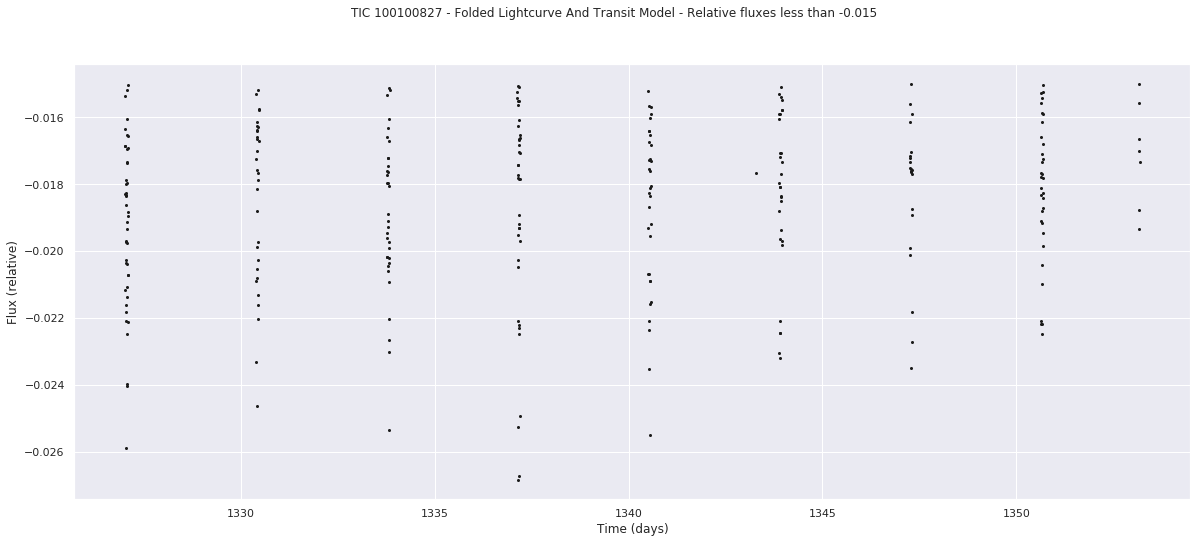

In [222]:
# Create a new DataFrame of data where only columns of flux less than "fluxLim" are considered
minTimeFlux = pd.DataFrame({
    'Time (days)': timeFlux["Time (days)"][timeFlux["Relative Fluxes"] < fluxLim],
    'Relative Fluxes': timeFlux["Relative Fluxes"][timeFlux["Relative Fluxes"] < fluxLim]
})

def minPlot():

    # Start figure and axis.
    fig, ax = plt.subplots(figsize=(20,8))

    # Plot the detrended fluxes as black circles.  We will plot them in sorted order.
    ax.plot(minTimeFlux["Time (days)"], minTimeFlux["Relative Fluxes"], 'ko',
           markersize=2)

    # Let's label the axes and define a title for the figure.
    fig.suptitle('TIC 100100827 - Folded Lightcurve And Transit Model - Relative fluxes less than ' + str(fluxLim))
    ax.set_ylabel("Flux (relative)")
    ax.set_xlabel("Time (days)")

    plt.show()
    
minPlot()

Now that we have these distances it is time to work out how to calculate the gap between them!

### WAIT HANG ON

Now that I can do this, I can make a *counterpart* dataframe of the main bulk if I want, too!

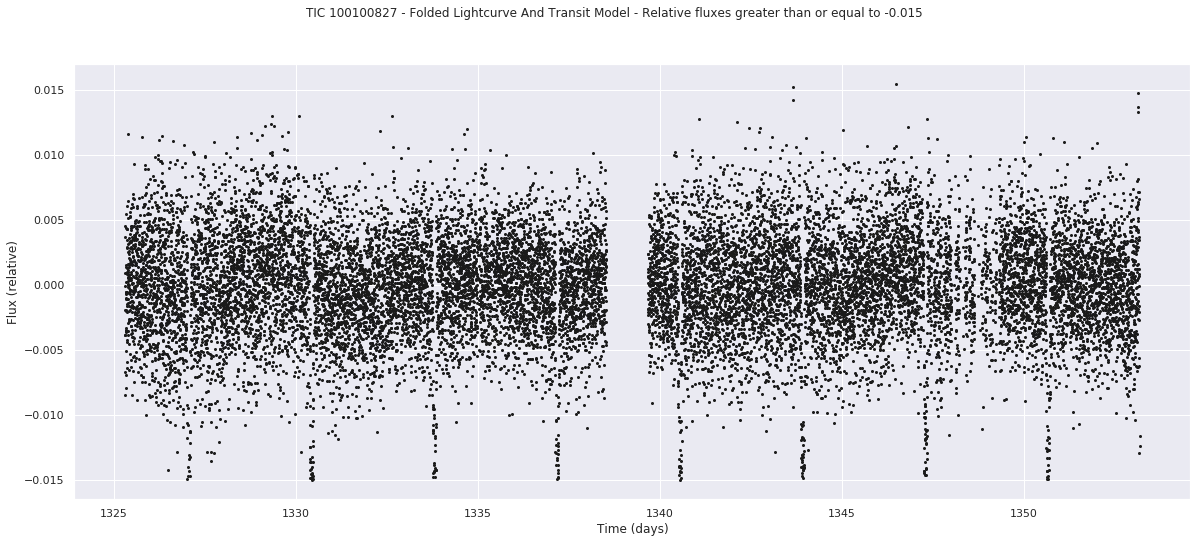

In [223]:
# Note: must use ">=" as the other part used "<"
# This makes sure that no data is ignored (ie, rare case where flux == fluxLim)

# Create a new DataFrame of data where only columns of flux greater than or equal to "fluxLim" are considered
maxTimeFlux = pd.DataFrame({
    'Time (days)': timeFlux["Time (days)"][timeFlux["Relative Fluxes"] >= fluxLim],
    'Relative Fluxes': timeFlux["Relative Fluxes"][timeFlux["Relative Fluxes"] >= fluxLim]
})

def maxPlot():

   # Start figure and axis.
    fig, ax = plt.subplots(figsize=(20,8))

    # Plot the detrended fluxes as black circles.  We will plot them in sorted order.
    ax.plot(maxTimeFlux["Time (days)"], maxTimeFlux["Relative Fluxes"], 'ko',
           markersize=2)

    # Let's label the axes and define a title for the figure.
    fig.suptitle('TIC 100100827 - Folded Lightcurve And Transit Model - Relative fluxes greater than or equal to ' + str(fluxLim))
    ax.set_ylabel("Flux (relative)")
    ax.set_xlabel("Time (days)")

    plt.show()
    
maxPlot()

(This also reminds me that, despite Flux being a measured unit (as opposed to a calculated unit) they still give us units in *Relative* flux - therefore it must be relative *to something*. It appears that it's relative to the *average* flux received, and this technically the flux values we are given are calculated (they are normalised to something) but, realistically, whether given is units of electrons per area per second, or given in this form, the graph should still look the same, and so whilst the units are not strictly given, the result should be identical.)

### Back to our regularly scheduled programming

Now that we have our plot of the "troughs" (ie, lowest spikes of relative flux) we should be able to calculate the gaps between them, and thus, make our own "Phase" generation program

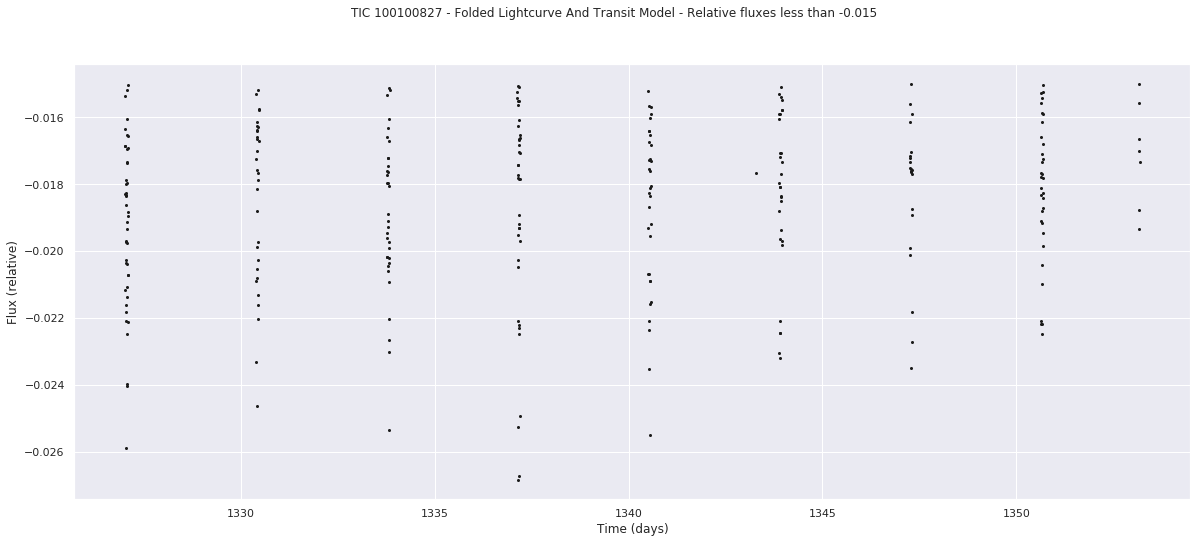

In [9]:
minPlot()

In [12]:
timeDiff = 1

In [13]:
timeCompare = pd.DataFrame({
    'T_n': list(minTimeFlux["Time (days)"][:-1]),
    'T_n+1': list(minTimeFlux["Time (days)"][1:])
})
timeCompare["T_diff"] = timeCompare["T_n+1"]-timeCompare["T_n"]
dayDiff = timeCompare[timeCompare["T_diff"] > timeDiff]
dayDiff

,T_n,T_n+1,T_diff
43,1327.088476,1330.398285,3.309809
73,1330.462175,1333.759473,3.297297
107,1333.834474,1337.128973,3.294499
145,1337.212308,1340.504019,3.291711
178,1340.583186,1343.297087,2.713901
209,1343.958200,1347.252645,3.294445
230,1347.323478,1350.627633,3.304155
263,1350.699855,1353.166507,2.466652


In [40]:
phaseShift = dayDiff["T_diff"].mean(axis=0)
phaseShift

3.1215587101671645

So it looks like there's an approx 3.1 day period between each spike. What I could therefore do is:
- Loop through the list until a difference of >1 is found
- Subtract this average from all times from that element *going forth*
- Continue the loop through the list until all of gaps have been shortened
- Plot the new list

In [225]:
def makePlot(df):

   # Start figure and axis.
    fig, ax = plt.subplots(figsize=(20,8))

    # Plot the detrended fluxes as black circles.  We will plot them in sorted order.
    ax.plot(df["Time (days)"], df["Relative Fluxes"], 'ko',
           markersize=2)

    # Let's label the axes and define a title for the figure.
    fig.suptitle('TIC 100100827 - Folded Lightcurve And Transit Model - Relative fluxes greater than or equal to ' + str(fluxLim))
    ax.set_ylabel("Flux (relative)")
    ax.set_xlabel("Time (days)")

    plt.show()

In [226]:
phaseList["Time (days)"].iloc[3]

1327.0204184449028

In [254]:
# Start by making a copy of the original dataframe
phaseList = timeFlux.copy()
t0 = phaseList["Time (days)"].iloc[0] + phaseShift
phaseList

,Time (days),Relative Fluxes
0,1325.299536,NaN
1,1325.300925,-0.000066
2,1325.302314,-0.003870
3,1325.303703,-0.003895
4,1325.305091,0.003641
...,...,...
20071,1353.176229,-0.018784
20072,1353.177618,-0.015583
20073,1353.179007,-0.011633
20074,1353.180396,-0.012428


In [255]:
for n, i in enumerate(phaseList["Time (days)"][1:]):
    #print("{}:\t{}\t|\t{}".format(n+1,i,t0))
        
    if i >= t0:
        phaseList["Time (days)"][n:] -= phaseShift #Subtracts "phaseShift" from all values in pL[n:] ie, here down
    
phaseList

/home/jdowzell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Time (days),Relative Fluxes
0,1325.299536,NaN
1,1325.300925,-0.000066
2,1325.302314,-0.003870
3,1325.303703,-0.003895
4,1325.305091,0.003641
...,...,...
20071,1328.203760,-0.018784
20072,1328.205148,-0.015583
20073,1328.206537,-0.011633
20074,1328.207926,-0.012428


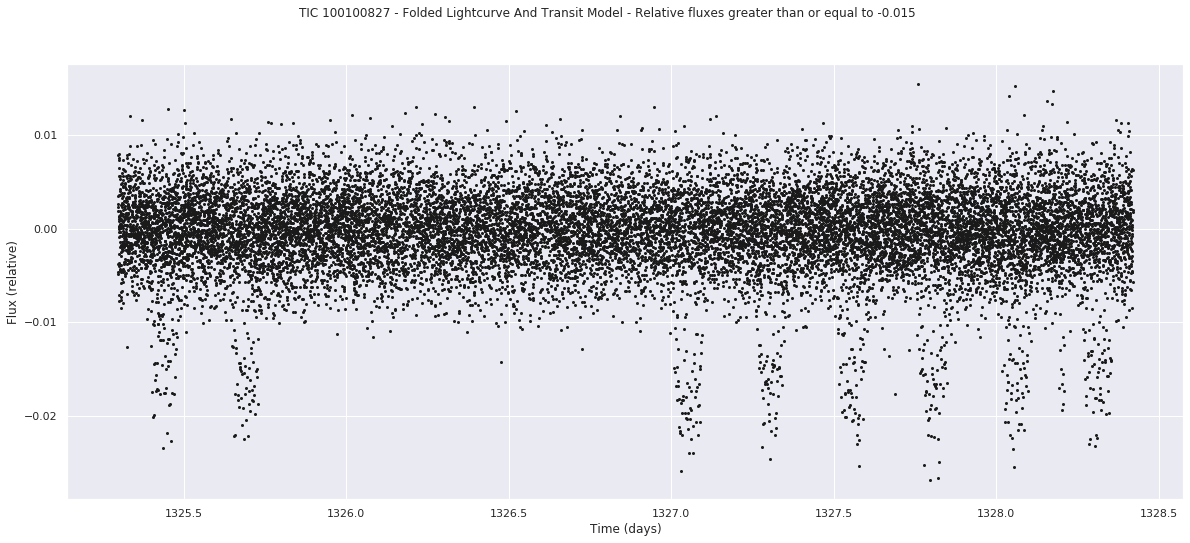

In [256]:
makePlot(phaseList)

Well that clearly didn't work